In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
import seaborn as sns
import os
from sklearn.preprocessing import MinMaxScaler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb
from sklearn.ensemble import GradientBoostingClassifier
import joblib
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load data set into pandas
df = pd.read_csv("heart_2022_Spark.csv")

# Display the first few rows of the DataFrame
# print("Initial DataFrame:")
# print(df.head())

# Drop the 'State' column if it exists
if 'State' in df.columns:
    df = df.drop(columns='State')

# Identify binary columns (for Yes/No and 0/1 values)
binary_columns = [column for column in df.columns if df[column].nunique() == 2]

# Convert binary columns to 0 and 1
for col in binary_columns:
    unique_values = df[col].unique()
    if set(unique_values) == {"Yes", "No"}:
        df[col] = df[col].map({"Yes": 1, "No": 0})

# Ensure 'HeartAttack' column is binary and not transformed or scaled
if df['HeartAttack'].dtype == 'object':
    df['HeartAttack'] = df['HeartAttack'].map({"Yes": 1, "No": 0})

# Extract the 'HeartAttack' column and keep it separate
heart_attack = df['HeartAttack']

# Identify categorical columns excluding 'HeartAttack'
categorical_columns = df.select_dtypes(include=["object"]).columns
categorical_columns = categorical_columns[categorical_columns != 'HeartAttack']

# Extract the categorical columns into a new DataFrame
Categorical_col = df[categorical_columns]

# Use pd.get_dummies to transform the categorical columns
Transform_df = pd.get_dummies(Categorical_col, dtype=int)

# Select numeric columns
numeric_columns = df.select_dtypes(include=["float64", "int64"]).columns

# Create a DataFrame for numeric columns
df_numeric = df[numeric_columns]

# Create standard scaler instance, fitting it, and scaling it
scaler = StandardScaler()
scaled_numeric_df = pd.DataFrame(scaler.fit_transform(df_numeric), columns=numeric_columns)

# Drop the original categorical and numeric columns from the original DataFrame
df = df.drop(columns=categorical_columns.tolist() + numeric_columns.tolist())

# Combine the original DataFrame (now without the dropped columns), dummy variables DataFrame,
merged_df = pd.concat([df.reset_index(drop=True), Transform_df.reset_index(drop=True), scaled_numeric_df.reset_index(drop=True)], axis=1)

# Add the 'HeartAttack' column back to the merged DataFrame
merged_df['HeartAttack'] = heart_attack.values

# Display the first few rows of the merged DataFrame
print("Merged DataFrame:")
merged_df.head()

Merged DataFrame:


,Sex_Female,Sex_Male,Age_Age 18 to 24,Age_Age 25 to 29,Age_Age 30 to 34,Age_Age 35 to 39,Age_Age 40 to 44,Age_Age 45 to 49,Age_Age 50 to 54,Age_Age 55 to 59,...,SleepHours,DiffWalking,Drinking,HeartAttack,Angina,Stroke,Asthma,SkinCancer,Depressed,KidneyDisease
0,1,0,0,0,0,0,0,0,0,0,...,-0.708017,-0.412723,-1.110712,0,-0.251104,-0.204903,-0.41919,3.336372,-0.514288,-0.215619
1,1,0,0,0,0,0,0,0,0,1,...,-1.400709,-0.412723,-1.110712,0,-0.251104,-0.204903,-0.41919,3.336372,-0.514288,-0.215619
2,1,0,0,0,0,0,1,0,0,0,...,1.370059,-0.412723,0.900323,0,-0.251104,-0.204903,-0.41919,-0.299727,-0.514288,-0.215619
3,0,1,0,0,0,0,0,0,0,0,...,-0.015325,-0.412723,-1.110712,1,-0.251104,4.880352,-0.41919,-0.299727,-0.514288,-0.215619
4,1,0,0,0,0,0,0,0,0,0,...,-0.015325,-0.412723,0.900323,0,-0.251104,-0.204903,-0.41919,-0.299727,-0.514288,-0.215619


In [3]:
# Split Data into Features and Target
X = merged_df.drop(columns="HeartAttack")
y = merged_df.HeartAttack

# Ensure the target variable is binary
print("Unique values in target 'HeartAttack':")
print(y.unique())

# Train a RandomForestClassifier Model
model = RandomForestClassifier()
model.fit(X, y)

Unique values in target 'HeartAttack':
[0 1]


RandomForestClassifier()

In [4]:
# Feature Importance Calculation
feautres_name = X.columns
importances =  model.feature_importances_
importance_df = pd.DataFrame({"Feature": feautres_name, "Importance": importances})
importance_df = importance_df.sort_values(by = "Importance", ascending=False)
importance_df

,Feature,Importance
37,BMI,0.200786
45,Angina,0.158676
42,SleepHours,0.083001
38,PhysicalHealth,0.063351
39,MentalHealth,0.049071
44,Drinking,0.022280
40,PhysicalActivity,0.022076
46,Stroke,0.021982
41,ChestScan,0.019201
47,Asthma,0.019167


<Axes: >

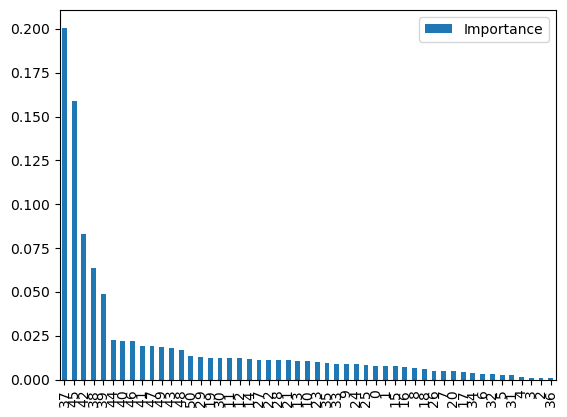

In [5]:
# Plotting Feature Importances
importance_df.plot(kind="bar")

In [6]:
# Filtering Important Features
important_features = importance_df[importance_df.Importance > 0.025]
important_features

,Feature,Importance
37,BMI,0.200786
45,Angina,0.158676
42,SleepHours,0.083001
38,PhysicalHealth,0.063351
39,MentalHealth,0.049071


In [7]:
# Creating DataFrame for PCA Data
pca_data = importance_df[~importance_df.Feature.isin(important_features.Feature)]
pca_data = merged_df[list(pca_data.Feature)]
pca_data.head()

,Drinking,PhysicalActivity,Stroke,ChestScan,Asthma,Depressed,DiffWalking,SkinCancer,KidneyDisease,ECigaretteUsage_Never used e-cigarettes in my entire life,...,"Race_Multiracial, Non-Hispanic","Diabetes_No, pre-diabetes or borderline diabetes",Age_Age 40 to 44,ECigaretteUsage_Use them some days,Age_Age 35 to 39,ECigaretteUsage_Use them every day,Age_Age 30 to 34,Age_Age 25 to 29,Age_Age 18 to 24,"Diabetes_Yes, but only during pregnancy (female)"
0,-1.110712,-1.865082,-0.204903,-0.849161,-0.41919,-0.514288,-0.412723,3.336372,-0.215619,1,...,0,0,0,0,0,0,0,0,0,0
1,-1.110712,0.536170,-0.204903,-0.849161,-0.41919,-0.514288,-0.412723,3.336372,-0.215619,1,...,0,0,0,0,0,0,0,0,0,0
2,0.900323,0.536170,-0.204903,1.177633,-0.41919,-0.514288,-0.412723,-0.299727,-0.215619,1,...,0,0,1,0,0,0,0,0,0,0
3,-1.110712,-1.865082,4.880352,-0.849161,-0.41919,-0.514288,-0.412723,-0.299727,-0.215619,1,...,0,0,0,0,0,0,0,0,0,0
4,0.900323,0.536170,-0.204903,-0.849161,-0.41919,-0.514288,-0.412723,-0.299727,-0.215619,1,...,0,0,0,0,0,0,0,0,0,0


In [8]:
# Separate important features
important_features = ['BMI', 'Angina', 'SleepHours', 'PhysicalHealth', 'MentalHealth']
important_features_data = merged_df[important_features]


In [9]:
# Separate features to apply PCA on
remaining_features = [col for col in merged_df.columns if col not in important_features + ['HeartAttack']]
pca_data = merged_df[remaining_features]

In [10]:
# Apply PCA to the remaining features
scaler = StandardScaler()
pca_data_scaled = scaler.fit_transform(pca_data)

In [11]:
# Apply PCA
pca = PCA(n_components=20)
X_pca = pca.fit_transform(pca_data_scaled)

In [12]:
# Convert PCA transformed data to DataFrame
transformed_data = pd.DataFrame(X_pca, columns=[f'PCA_{i+1}' for i in range(X_pca.shape[1])])

In [13]:
# Combine important features and PCA-transformed features
prepped_data = pd.concat([merged_df['HeartAttack'], important_features_data, transformed_data], axis=1)

In [14]:
# Balance the dataset
fract_remove = 0.80
majority_data = prepped_data[prepped_data.HeartAttack == 0]
count_of_majority = len(majority_data)
minority_data = prepped_data[prepped_data.HeartAttack == 1]
sample_remove = majority_data.sample(int(fract_remove * count_of_majority)).index
majority_data = majority_data.drop(sample_remove)

In [15]:
# Combine balanced majority and minority data
final_data = pd.concat([majority_data, minority_data], axis="rows")
# Save the final data to a CSV file
final_data.to_csv ("ready_for_ML.csv", index=False)

In [16]:
# Calculate the proportions of majority and minority classes in final data
print(len(majority_data)/len(final_data), len(minority_data)/len(final_data))

0.7809009102192801 0.2190990897807199


In [17]:
# Load data set into pandas
df = pd.read_csv("ready_for_ML.csv")
df.head()

,HeartAttack,BMI,Angina,SleepHours,PhysicalHealth,MentalHealth,PCA_1,PCA_2,PCA_3,PCA_4,...,PCA_11,PCA_12,PCA_13,PCA_14,PCA_15,PCA_16,PCA_17,PCA_18,PCA_19,PCA_20
0,0,-0.306929,-0.251104,-0.708017,-0.491795,-0.524718,-0.192206,-2.471079,-0.246111,-1.144088,...,-0.728172,0.325379,0.153838,-0.669106,1.041109,0.271357,1.313249,0.193668,-0.551299,-0.141935
1,0,-0.860988,-0.251104,-0.015325,-0.491795,-0.524718,-0.396896,-0.658791,0.461921,-0.686961,...,0.472161,0.040513,-0.259673,-0.813421,-0.188853,-0.899336,1.591026,-0.353047,-0.099310,1.390767
2,0,-0.116615,-0.251104,0.677367,-0.491795,-0.524718,0.690016,-1.898825,0.343490,-0.853217,...,-1.260548,0.545593,0.330383,-0.939608,0.602416,-0.719001,1.280162,0.116172,-0.284517,0.350657
3,0,0.101325,-0.251104,0.677367,0.456787,0.569190,1.205148,-1.863402,0.496715,-0.881356,...,-1.324276,-0.215042,-0.974303,-1.476976,0.332867,-0.831491,1.219932,0.401920,-0.869513,0.013611
4,0,-0.822618,-0.251104,-0.708017,-0.491795,-0.524718,0.168563,-1.909389,0.544586,-0.886750,...,-1.428007,0.759474,0.418378,-0.826613,0.666195,-0.946783,1.186941,0.140119,-0.373126,0.179561


In [18]:
# Save the df_NN to CSV file
df_NN = df[['BMI', 'Angina', 'SleepHours', 'PhysicalHealth', 'MentalHealth']]
final_data.to_csv("ready_for_NN.csv", index=False)

In [19]:
# Split the data into training and testing sets
X = df.drop(columns="HeartAttack")
y = df["HeartAttack"]
X_train, X_test, y_train, y_test = train_test_split(X, y,shuffle=True, test_size=0.3, random_state=42, stratify=y)

# Create and fit the Logistic Regression model with class weights
classifier = LogisticRegression(solver='lbfgs', max_iter=200, random_state=42, class_weight='balanced')
classifier.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred_test = classifier.predict(X_test)
print("Test Set Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred_test))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_test))
print("Classification Report:\n", classification_report(y_test, y_pred_test))


Test Set Evaluation:
Accuracy: 0.8243406309257024
Confusion Matrix:
 [[15347  2773]
 [ 1303  3781]]
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.85      0.88     18120
           1       0.58      0.74      0.65      5084

    accuracy                           0.82     23204
   macro avg       0.75      0.80      0.77     23204
weighted avg       0.85      0.82      0.83     23204



In [20]:
# Create and fit the Random Forest model
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_classifier.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred_test_rf = rf_classifier.predict(X_test)
print("Random Forest Test Set Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred_test_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_test_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_test_rf))


Random Forest Test Set Evaluation:
Accuracy: 0.8516204102740906
Confusion Matrix:
 [[17069  1051]
 [ 2392  2692]]
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.94      0.91     18120
           1       0.72      0.53      0.61      5084

    accuracy                           0.85     23204
   macro avg       0.80      0.74      0.76     23204
weighted avg       0.84      0.85      0.84     23204



In [21]:
# Create and fit the Gradient Boosting model
gb_classifier = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_classifier.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred_test_gb = gb_classifier.predict(X_test)
print("Gradient Boosting Test Set Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred_test_gb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_test_gb))
print("Classification Report:\n", classification_report(y_test, y_pred_test_gb))


Gradient Boosting Test Set Evaluation:
Accuracy: 0.8672642647819342
Confusion Matrix:
 [[17369   751]
 [ 2329  2755]]
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.96      0.92     18120
           1       0.79      0.54      0.64      5084

    accuracy                           0.87     23204
   macro avg       0.83      0.75      0.78     23204
weighted avg       0.86      0.87      0.86     23204



In [22]:
# Create and fit the XGBoost model
xgb_classifier = xgb.XGBClassifier(random_state=42, scale_pos_weight=len(y_train[y_train==0]) / len(y_train[y_train==1]))
xgb_classifier.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred_test_xgb = xgb_classifier.predict(X_test)
print("XGBoost Test Set Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred_test_xgb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_test_xgb))
print("Classification Report:\n", classification_report(y_test, y_pred_test_xgb))


XGBoost Test Set Evaluation:
Accuracy: 0.8194707808998448
Confusion Matrix:
 [[15273  2847]
 [ 1342  3742]]
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.84      0.88     18120
           1       0.57      0.74      0.64      5084

    accuracy                           0.82     23204
   macro avg       0.74      0.79      0.76     23204
weighted avg       0.84      0.82      0.83     23204



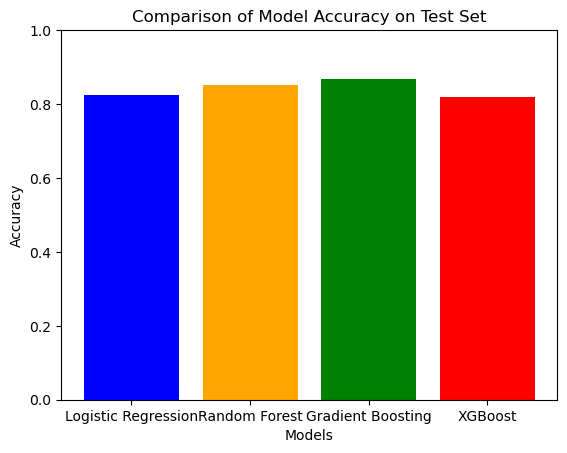

In [23]:
# Plot the comparison of accuracy
labels = ['Logistic Regression', 'Random Forest', 'Gradient Boosting', 'XGBoost']
accuracies = [
    accuracy_score(y_test, y_pred_test),
    accuracy_score(y_test, y_pred_test_rf),
    accuracy_score(y_test, y_pred_test_gb),
    accuracy_score(y_test, y_pred_test_xgb)
]

plt.bar(labels, accuracies, color=['blue', 'orange', 'green', 'red'])
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Comparison of Model Accuracy on Test Set')
plt.ylim(0, 1)
plt.show()


$$ Precision = TP /(TP + FP) $$

$$ Recall = TP / (TP + FN) $$

In [24]:
# Load data set into pandas
data = pd.read_csv("heart_2022_Spark.csv")

In [25]:
# Defining Columns to Keep for Feature Selection Models
important_features = ['BMI', 'Angina', 'SleepHours', 'PhysicalHealth', 'MentalHealth']

In [26]:
# Creating DataFrame with Selected Columns and Target Column
df = data[important_features]
df["HeartAttack"] = data.HeartAttack

In [27]:
# Encoding Categorical Columns
encoder = LabelEncoder()
df["Angina"] = encoder.fit_transform(df.Angina)
df["HeartAttack"] = encoder.fit_transform(df["HeartAttack"])

In [28]:
# Saving Label Encoder to a File
joblib.dump(encoder,"label_encoder.pkl")

['label_encoder.pkl']

In [29]:
# Scaling Numeric Columns
scaler = MinMaxScaler()
col_to_scale = df.select_dtypes(include="float64")
scaled_columns = scaler.fit_transform(col_to_scale)
scaled_data = pd.DataFrame(scaled_columns, columns=col_to_scale.columns)

In [30]:
# Saving Label scaler to a File
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']

In [31]:
# Creating Final Prepped Data by Concatenating Scaled and Encoded Columns
prepped_data = pd.concat([scaled_data,df[["Angina","HeartAttack"]]],axis="columns")

In [32]:
from xgboost import XGBClassifier

# Split Data into Features and Target
X = prepped_data.drop(columns="HeartAttack")
y = prepped_data.HeartAttack

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, shuffle=True, random_state=42)

# Train an XGBoost Classifier Model
model = XGBClassifier(random_state=42)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [33]:
# Evaluating the XGB Model
model.score(X_test,y_test)

0.9466874301062908

In [34]:
# Saving Label model to a File
joblib.dump(model,"rf_classifier.pkl")

['rf_classifier.pkl']